Обучить мнист


MNIST это набор картинок размер которых 1x28x28. Берите датасет в котором пиксель может быть вещественным числом от 0 до 1. Просто там есть датасет у которого значение пикселя либо 0 либо 1, его скипаем.


Это задача классификации, на каждой картинке написана цифра, и нужно предктнуть что это за цифра


Архитектура MLP


1) написать свой датасет(класс) и даталаудер
2) написать архитектуру MLP+классификатор
3) использовать либо SGD либо Adam в качестве оптимизатора
4) использовать CrossEntropyLoss в качестве лоссфункции
5) использовать ReLU в качестве функции активации 
6) переводить модель на cuda, переводить номер класса в one hot вектор, использовать argmax для обратного преобразования 


слой классификации это обычный линейный слой, у которого функция активации Softmax(но это не обязательно, нужно только для того чтобы увидеть именно вероятности)




https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(next(iter(test_dataloader))[0].shape)
print(next(iter(test_dataloader))[1].shape)


for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break




torch.Size([64, 1, 28, 28])
torch.Size([64])
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


In [5]:
brope = next(iter(test_dataloader))[0][0][0]
print(brope.shape)
print(torch.unique(brope, sorted = True))

torch.Size([28, 28])
tensor([0.0000, 0.0039, 0.0118, 0.0196, 0.0353, 0.0549, 0.0667, 0.0706, 0.0745,
        0.0824, 0.0863, 0.1216, 0.1373, 0.1412, 0.1490, 0.1569, 0.1725, 0.2039,
        0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431, 0.2588, 0.2627, 0.2824,
        0.2941, 0.3020, 0.3255, 0.3294, 0.4157, 0.4471, 0.4510, 0.4745, 0.4941,
        0.5059, 0.5216, 0.5490, 0.5922, 0.6235, 0.6392, 0.6510, 0.6667, 0.7137,
        0.7255, 0.7333, 0.7765, 0.7961, 0.8039, 0.8118, 0.8196, 0.8588, 0.8667,
        0.8706, 0.8784, 0.8824, 0.8902, 0.8980, 0.9137, 0.9255, 0.9333, 0.9412,
        0.9451, 0.9490, 0.9725, 0.9765, 0.9804, 0.9843, 0.9922, 0.9961, 1.0000])


In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            # nn.Softmax(10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


In [25]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        print(batch, X.shape, y)
        break
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [26]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    break
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
0 torch.Size([64, 1, 28, 28]) tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])
Done!


In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [13]:
print(test_data.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [ ]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]
y_true = []
y_pred = []

model.eval()
for i in range(10):
    x, y = test_data[i][0], test_data[i][1]

    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "seven", Actual: "seven"
Predicted: "two", Actual: "two"
Predicted: "one", Actual: "one"
Predicted: "zero", Actual: "zero"
Predicted: "four", Actual: "four"
Predicted: "one", Actual: "one"
Predicted: "seven", Actual: "four"
Predicted: "nine", Actual: "nine"
Predicted: "six", Actual: "five"
Predicted: "nine", Actual: "nine"


In [ ]:
# расчитайте и выведите метрики

print("Отчет по классификации:")

classes = train_dataset.classes
print(classification_report(y_true, y_pred, target_names=classes))


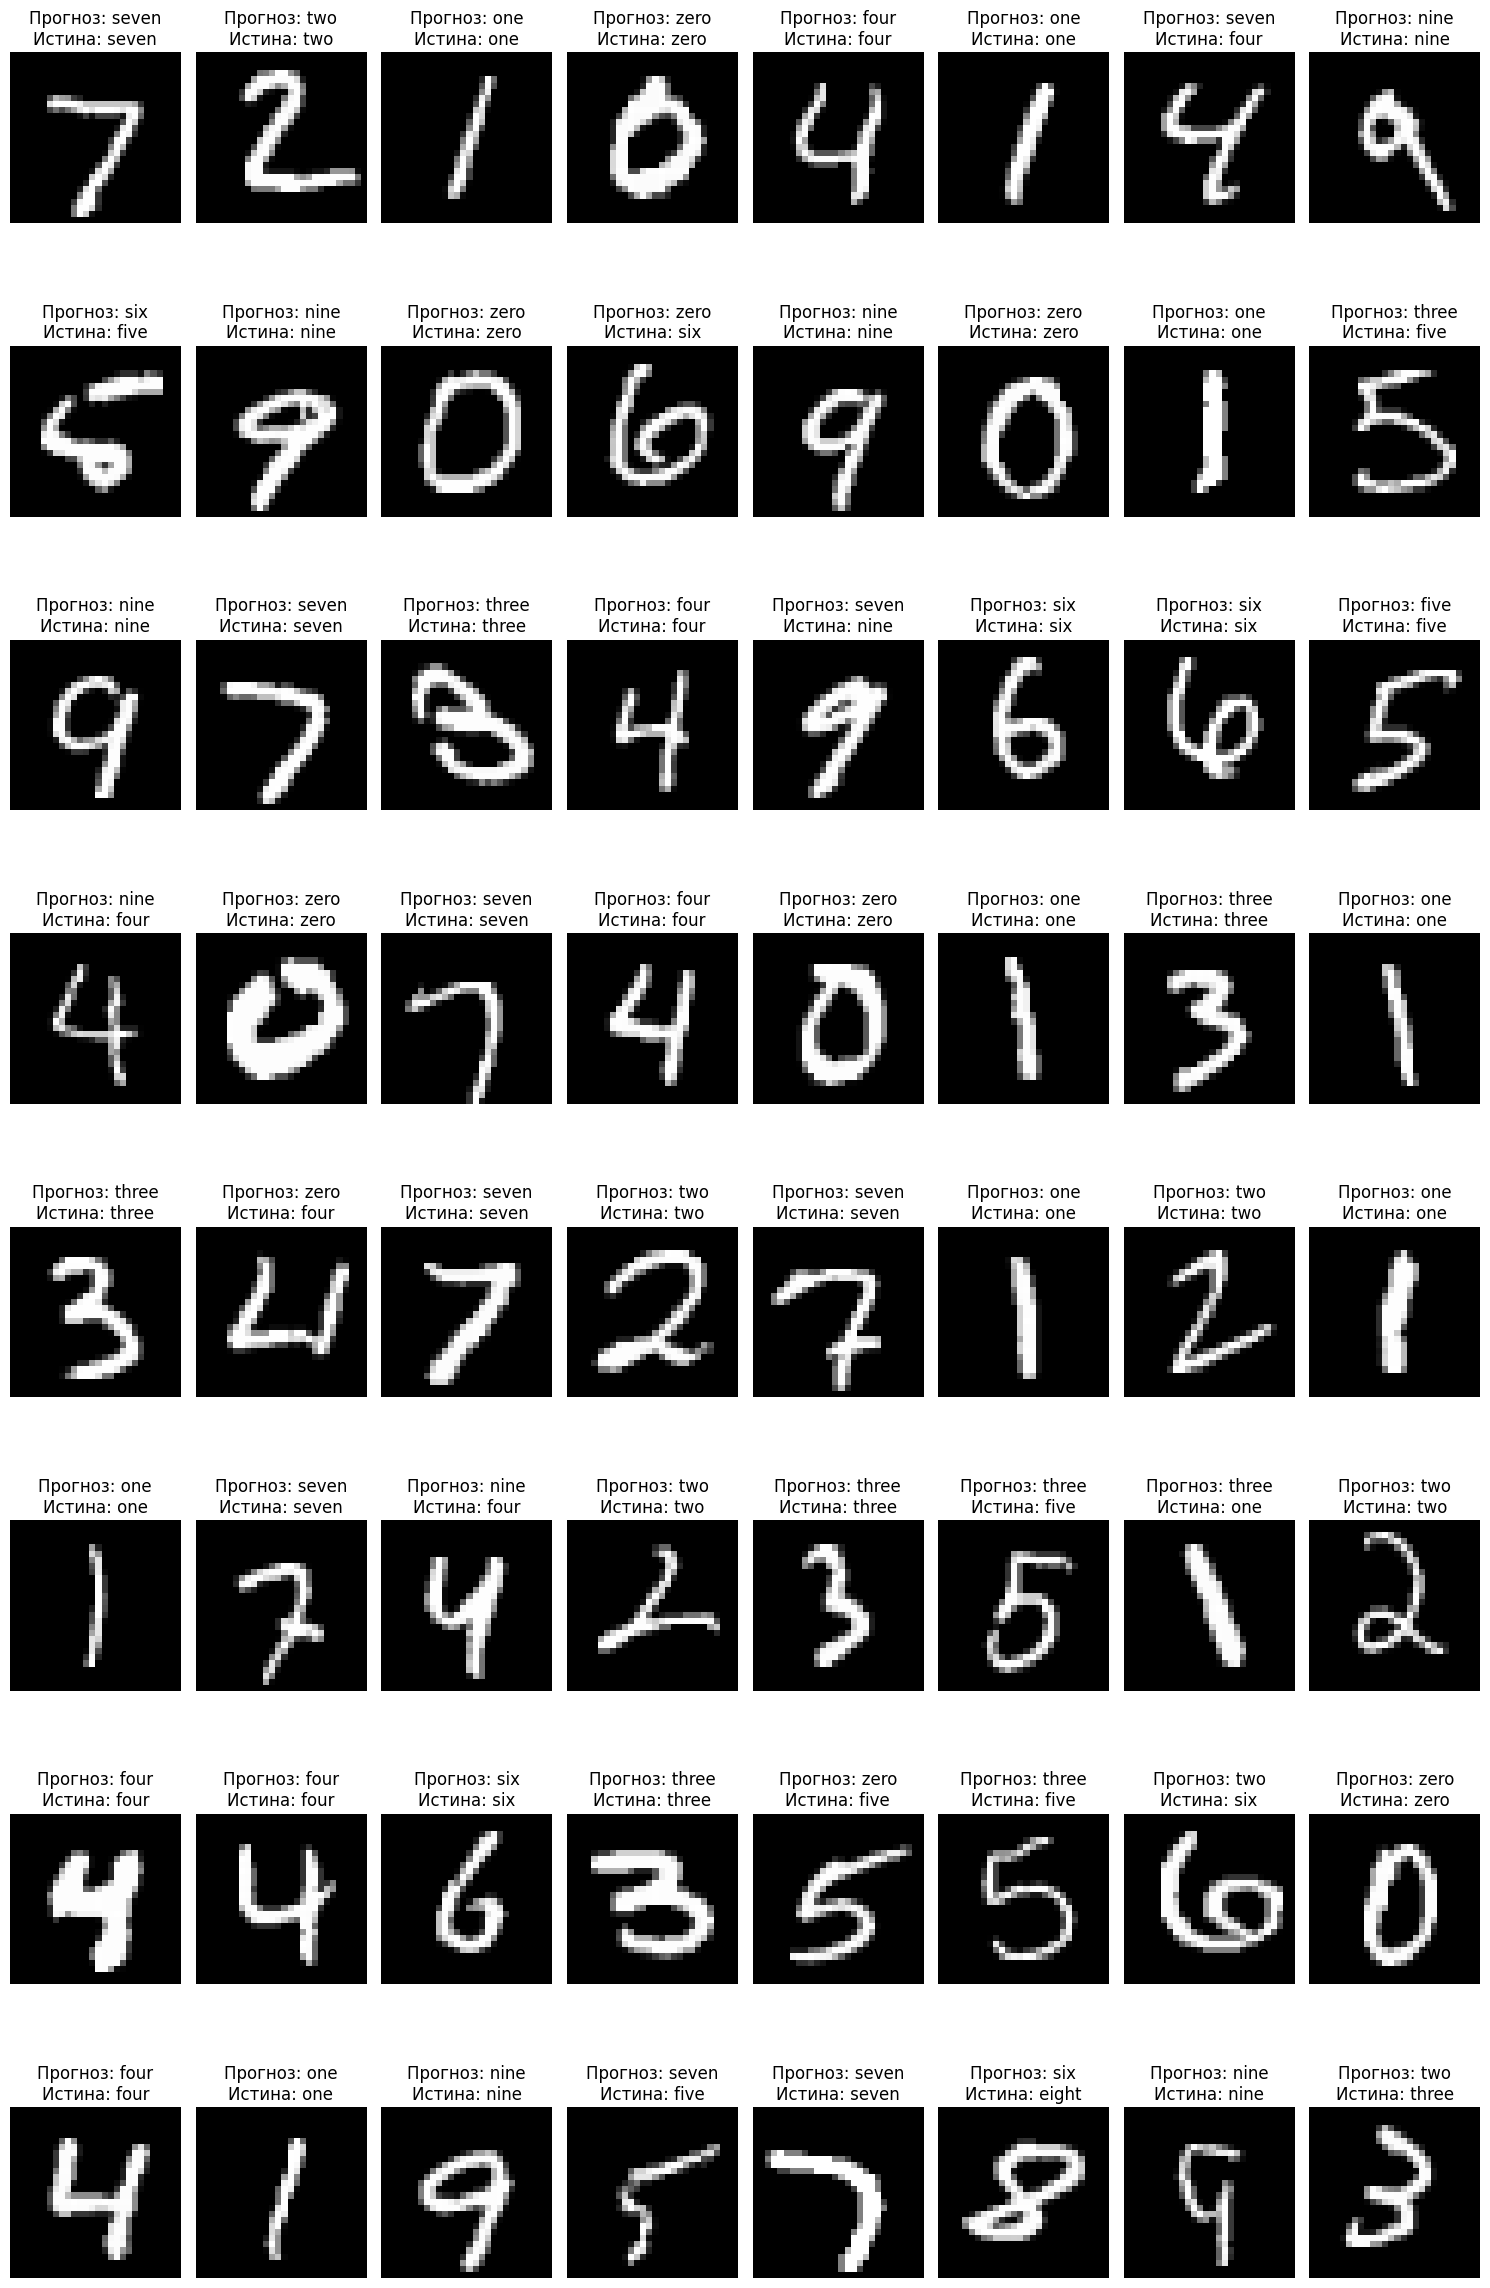

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# определите метод денормализации
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# получите батч и перенесите его на устройство
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
images = images.to(device)


# получите прогнозные метки
outputs = model(images)
_, predicted = torch.max(outputs, 1)


batch_size = images.size(0)
# batch_size = 32

n_cols = 8
n_rows = 8

fig = plt.figure(figsize=(15, 24))

for i in range(batch_size):

    plt.subplot(n_rows, n_cols, i+1)

    img = images[i].cpu()
    img = img.squeeze(0)  

    plt.imshow(img, cmap='gray')  
    plt.title(f'Прогноз: {classes[predicted[i]]}\nИстина: {classes[labels[i]]}',fontsize=12)
    plt.axis('off')




plt.tight_layout()
plt.show()
